## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, kernel_regularizer, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
regulizer_ratio = [1e-2, 1e-4, 1e-8, 1e-12]
kernel_regularizer = [keras.regularizers.l1, keras.regularizers.l2, keras.regularizers.l1_l2]

In [9]:
import itertools
results = {}
for ratio, regular in itertools.product(regulizer_ratio,kernel_regularizer):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print('Regulizer {regular}, Ratio {ratio}'.format(regular=regular, ratio=ratio))
    model = build_mlp(input_shape=x_train.shape[1:], kernel_regularizer=regular(ratio))
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "%s-%s" % (str(regular), str(ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Regulizer <function l1 at 0x000001BA77D980D8>, Ratio 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1

Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Regulizer <function l2 at 0x000001BA77D9C3A8>, Ratio 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________

Epoch 47/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6182 - accuracy: 0.5251 - val_loss: 1.6951 - val_accuracy: 0.4894
Epoch 48/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6142 - accuracy: 0.5264 - val_loss: 1.6887 - val_accuracy: 0.4960
Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6121 - accuracy: 0.5275 - val_loss: 1.7236 - val_accuracy: 0.4849
Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6089 - accuracy: 0.5274 - val_loss: 1.6619 - val_accuracy: 0.5048
Regulizer <function l1_l2 at 0x000001BA77D9C438>, Ratio 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   


Epoch 45/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4615 - accuracy: 0.0961 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4615 - accuracy: 0.0973 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4615 - accuracy: 0.0981 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4614 - accuracy: 0.0979 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4614 - accuracy: 0.0991 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.4614 - accuracy: 0.0972 - val_loss: 2.4613 - val_accuracy: 0.1000
Regulizer <function l1 at 0x000001BA77D980D8>, Ratio 0.0001
Model: "model_1"
___________________________________

Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.9104 - accuracy: 0.6157 - val_loss: 3.1615 - val_accuracy: 0.5187
Epoch 44/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.8716 - accuracy: 0.6173 - val_loss: 3.1779 - val_accuracy: 0.5003
Epoch 45/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.8330 - accuracy: 0.6172 - val_loss: 3.2163 - val_accuracy: 0.4929
Epoch 46/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7890 - accuracy: 0.6228 - val_loss: 3.0556 - val_accuracy: 0.5251
Epoch 47/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7502 - accuracy: 0.6255 - val_loss: 3.1098 - val_accuracy: 0.5004
Epoch 48/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7106 - accuracy: 0.6267 - val_loss: 2.9550 - val_accuracy: 0.5309
Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.6776 - accuracy: 0.6257 - val_

Epoch 41/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1328 - accuracy: 0.6533 - val_loss: 1.5211 - val_accuracy: 0.5279
Epoch 42/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1239 - accuracy: 0.6544 - val_loss: 1.5126 - val_accuracy: 0.5300
Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1106 - accuracy: 0.6602 - val_loss: 1.5574 - val_accuracy: 0.5172
Epoch 44/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0979 - accuracy: 0.6629 - val_loss: 1.4843 - val_accuracy: 0.5372
Epoch 45/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0854 - accuracy: 0.6683 - val_loss: 1.5554 - val_accuracy: 0.5173
Epoch 46/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0739 - accuracy: 0.6712 - val_loss: 1.4771 - val_accuracy: 0.5426
Epoch 47/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0676 - accuracy: 0.6749 - val_

Epoch 39/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.8022 - accuracy: 0.4683 - val_loss: 1.8107 - val_accuracy: 0.4632
Epoch 40/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7965 - accuracy: 0.4685 - val_loss: 1.8291 - val_accuracy: 0.4490
Epoch 41/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7923 - accuracy: 0.4690 - val_loss: 1.8254 - val_accuracy: 0.4571
Epoch 42/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7867 - accuracy: 0.4710 - val_loss: 1.8038 - val_accuracy: 0.4620
Epoch 43/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7806 - accuracy: 0.4719 - val_loss: 1.8050 - val_accuracy: 0.4645
Epoch 44/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7763 - accuracy: 0.4717 - val_loss: 1.9220 - val_accuracy: 0.4244
Epoch 45/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7727 - accuracy: 0.4739 - val_

Epoch 37/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0410 - accuracy: 0.6349 - val_loss: 1.3576 - val_accuracy: 0.5257
Epoch 38/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0276 - accuracy: 0.6388 - val_loss: 1.3697 - val_accuracy: 0.5264
Epoch 39/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0203 - accuracy: 0.6429 - val_loss: 1.3468 - val_accuracy: 0.5237
Epoch 40/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.0045 - accuracy: 0.6474 - val_loss: 1.3555 - val_accuracy: 0.5277
Epoch 41/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.9938 - accuracy: 0.6503 - val_loss: 1.3163 - val_accuracy: 0.5371
Epoch 42/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.9808 - accuracy: 0.6554 - val_loss: 1.3437 - val_accuracy: 0.5295
Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.9702 - accuracy: 0.6603 - val_

Epoch 35/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0513 - accuracy: 0.6306 - val_loss: 1.3635 - val_accuracy: 0.5279
Epoch 36/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0400 - accuracy: 0.6338 - val_loss: 1.3694 - val_accuracy: 0.5207
Epoch 37/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0300 - accuracy: 0.6379 - val_loss: 1.3942 - val_accuracy: 0.5162
Epoch 38/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0162 - accuracy: 0.6420 - val_loss: 1.3233 - val_accuracy: 0.5387
Epoch 39/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0046 - accuracy: 0.6453 - val_loss: 1.3572 - val_accuracy: 0.5331
Epoch 40/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.9947 - accuracy: 0.6491 - val_loss: 1.4683 - val_accuracy: 0.5007
Epoch 41/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.9800 - accuracy: 0.6547 - val_

Epoch 33/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7382 - accuracy: 0.4994 - val_loss: 1.7905 - val_accuracy: 0.4712
Epoch 34/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7220 - accuracy: 0.5026 - val_loss: 1.7581 - val_accuracy: 0.4882
Epoch 35/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7091 - accuracy: 0.5056 - val_loss: 1.7515 - val_accuracy: 0.4890
Epoch 36/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6963 - accuracy: 0.5054 - val_loss: 1.7237 - val_accuracy: 0.4943
Epoch 37/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6855 - accuracy: 0.5065 - val_loss: 1.7634 - val_accuracy: 0.4642
Epoch 38/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6755 - accuracy: 0.5086 - val_loss: 1.7355 - val_accuracy: 0.4890
Epoch 39/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6656 - accuracy: 0.5103 - val_

Epoch 31/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.1007 - accuracy: 0.6138 - val_loss: 1.5359 - val_accuracy: 0.4644
Epoch 32/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0899 - accuracy: 0.6169 - val_loss: 1.3380 - val_accuracy: 0.5214
Epoch 33/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0751 - accuracy: 0.6218 - val_loss: 1.3432 - val_accuracy: 0.5301
Epoch 34/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0639 - accuracy: 0.6297 - val_loss: 1.3807 - val_accuracy: 0.5170
Epoch 35/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0509 - accuracy: 0.6296 - val_loss: 1.3482 - val_accuracy: 0.5222
Epoch 36/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0450 - accuracy: 0.6325 - val_loss: 1.3354 - val_accuracy: 0.5315
Epoch 37/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0273 - accuracy: 0.6381 - val_

Epoch 29/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1336 - accuracy: 0.6017 - val_loss: 1.3574 - val_accuracy: 0.5225
Epoch 30/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1170 - accuracy: 0.6067 - val_loss: 1.3799 - val_accuracy: 0.5219
Epoch 31/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1042 - accuracy: 0.6124 - val_loss: 1.3647 - val_accuracy: 0.5192
Epoch 32/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0905 - accuracy: 0.6144 - val_loss: 1.3926 - val_accuracy: 0.5184
Epoch 33/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0783 - accuracy: 0.6203 - val_loss: 1.3506 - val_accuracy: 0.5244
Epoch 34/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0635 - accuracy: 0.6270 - val_loss: 1.3771 - val_accuracy: 0.5217
Epoch 35/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0545 - accuracy: 0.6307 - val_

Epoch 27/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.8941 - accuracy: 0.4889 - val_loss: 1.9034 - val_accuracy: 0.4787
Epoch 28/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.8577 - accuracy: 0.4907 - val_loss: 1.8996 - val_accuracy: 0.4626
Epoch 29/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.8282 - accuracy: 0.4912 - val_loss: 1.8725 - val_accuracy: 0.4712
Epoch 30/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.8004 - accuracy: 0.4951 - val_loss: 1.8205 - val_accuracy: 0.4834
Epoch 31/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7766 - accuracy: 0.4967 - val_loss: 1.8026 - val_accuracy: 0.4873
Epoch 32/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7560 - accuracy: 0.4988 - val_loss: 1.7819 - val_accuracy: 0.4866
Epoch 33/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7387 - accuracy: 0.4998 - val_

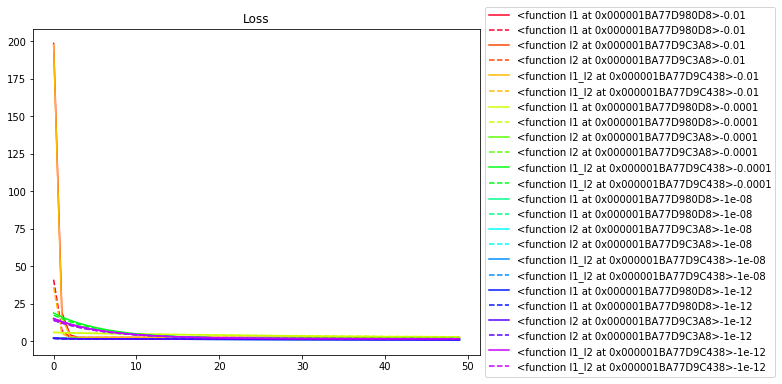

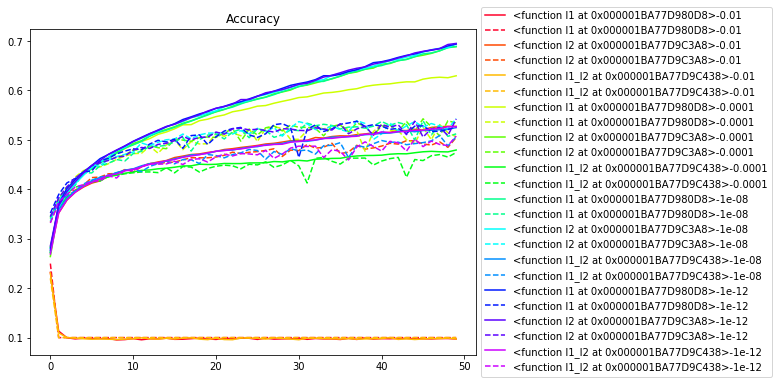

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()